In [1]:
import io
import sys
PATH = 'D:/Anderson/Downloads/SLF4SA-main/'
DIR_DATA = 'D:/Anderson/Downloads/SLF4SA-main/data/input/'
sys.path.append(PATH) if PATH not in list(sys.path) else None
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing

from sklearn.pipeline import FeatureUnion
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler


from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, precision_score

from logic.utils import Utils
from logic.classifiers import Classifiers
from logic.text_processing import TextProcessing
from logic.lexical_vectorizer import LexicalVectorizer
from root import DIR_RESULTS

# Variable initialization 

In [2]:
lang = 'es'
iteration = 10
fold = 10
classifiers = Classifiers.dict_classifiers
tp = TextProcessing(lang=lang)
lv = LexicalVectorizer(lang=lang, text_processing=tp)
ut = Utils(lang=lang, text_processing=tp)

# Import data

In [3]:
print('+ Import training...')
x, y = ut.get_data(file_name='tass2020_emotion_train')
print('+ Import test...')
x_eval, y_eval = ut.get_data(file_name='tass2020_emotion_dev')

+ Import training...
		 - Dataset size :(x: 5886 , y: 5886)
+ Import test...
		 - Dataset size :(x: 857 , y: 857)


# Feature extraction

In [4]:
x = lv.transform(x)
x_eval = lv.transform(x_eval)
print('- train:\n', sorted(Counter(y).items()))
print('- test: \n', sorted(Counter(y_eval).items()))

- train:
 [('anger ', 600), ('disgust ', 113), ('fear ', 67), ('joy ', 1270), ('others', 1), ('others ', 2888), ('sadness ', 706), ('surprise ', 241)]
- test: 
 [('anger ', 87), ('disgust ', 16), ('fear ', 10), ('joy ', 185), ('others ', 421), ('sadness ', 103), ('surprise ', 35)]


# Over Sampling

In [5]:
k_fold = ShuffleSplit(n_splits=fold, test_size=0.25, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
ros_train = RandomOverSampler(random_state=1000)
x_train, y_train = ros_train.fit_resample(x_train, y_train)
x_test, y_test = ros_train.fit_resample(x_test, y_test)
print('- train:\n', sorted(Counter(y_train).items()))
print('- test:\n', sorted(Counter(y_test).items()))

- train:
 [('anger ', 2022), ('disgust ', 2022), ('fear ', 2022), ('joy ', 2022), ('others', 2022), ('others ', 2022), ('sadness ', 2022), ('surprise ', 2022)]
- test:
 [('anger ', 866), ('disgust ', 866), ('fear ', 866), ('joy ', 866), ('others ', 866), ('sadness ', 866), ('surprise ', 866)]


In [6]:
shape = x_train.shape[1:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_eval = scaler.transform(x_eval)

In [7]:
lb = LabelEncoder()
y_train = lb.fit_transform([i.rstrip() for i in y_train.to_list()])
y_eval = lb.transform([i.rstrip() for i in y_eval.to_list()])
y_test = lb.transform([i.rstrip() for i in y_test.to_list()])

In [8]:
y_train

array([3, 5, 3, ..., 6, 6, 6], dtype=int64)

# NN Architecture

In [9]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.Input(shape=shape),
                                 keras.layers.Dense(21, activation="softmax"),
                                 keras.layers.Dense(14, activation="relu"),
                                 keras.layers.Dense(7, activation="softmax")
                                ])
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21)                588       
                                                                 
 dense_1 (Dense)             (None, 14)                308       
                                                                 
 dense_2 (Dense)             (None, 7)                 105       
                                                                 
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


# Training

Epoch 1/50
506/506 [==============================] - 2s 2ms/step - loss: 1.9146 - accuracy: 0.2463 - val_loss: 1.9629 - val_accuracy: 0.1429
Epoch 2/50
506/506 [==============================] - 1s 2ms/step - loss: 1.8985 - accuracy: 0.2499 - val_loss: 1.9732 - val_accuracy: 0.1429
Epoch 3/50
506/506 [==============================] - 1s 2ms/step - loss: 1.8946 - accuracy: 0.2500 - val_loss: 1.9744 - val_accuracy: 0.1429
Epoch 4/50
506/506 [==============================] - 1s 2ms/step - loss: 1.8913 - accuracy: 0.2499 - val_loss: 1.9735 - val_accuracy: 0.1429
Epoch 5/50
506/506 [==============================] - 1s 2ms/step - loss: 1.8877 - accuracy: 0.2499 - val_loss: 1.9717 - val_accuracy: 0.1429
Epoch 6/50
506/506 [==============================] - 1s 2ms/step - loss: 1.8837 - accuracy: 0.2499 - val_loss: 1.9710 - val_accuracy: 0.1429
Epoch 7/50
506/506 [==============================] - 1s 2ms/step - loss: 1.8785 - accuracy: 0.2501 - val_loss: 1.9686 - val_accuracy: 0.1429
Epoch 

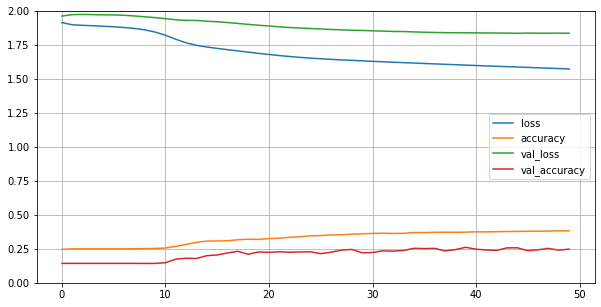

In [10]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [11]:
score = model.evaluate(x_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

y_predict = []
for features in tqdm(x_test):
    features = features.reshape(1, -1)
    value_prob = model.predict(features)
    value = np.argmax(value_prob, axis=1)
    y_predict.append(value)

accuracy_predict = accuracy_score(y_test, y_predict)
print('Accuracy: {0}'.format(round(np.mean(accuracy_predict), 2)))
print(classification_report(y_test, y_predict))

190/190 [==============================] - 0s 1ms/step - loss: 1.8367 - accuracy: 0.2478
Test Score: 1.8366857767105103
Test Accuracy: 0.24777300655841827


100%|██████████| 6062/6062 [04:43<00:00, 21.38it/s]

Accuracy: 0.25
              precision    recall  f1-score   support

           0       0.28      0.42      0.34       866
           1       0.23      0.25      0.24       866
           2       0.18      0.18      0.18       866
           3       0.19      0.07      0.11       866
           4       0.28      0.44      0.34       866
           5       0.29      0.20      0.23       866
           6       0.23      0.17      0.20       866

    accuracy                           0.25      6062
   macro avg       0.24      0.25      0.23      6062
weighted avg       0.24      0.25      0.23      6062

